# INFO 204 Assignment 2

__STUDENT ID:__ 4183298

__NAME:__ George Cui

## Precursors

The following cell will import the code and data needed (or at least be potentially helpful) for this assignment.

The first two helper functions _may_ be useful in Part 1 of the assignment:

* The `extract_model_stats()` function will be helpful if you choose to construct a linear model using scikit-learn (i.e., a LinearRegression object), and will provide an easy to interpret data frame of the model coeficients.

* The `categorical_numeric_interaction()` function can be used within a `ColumnTransformer` to introduce an interaction term between a categorical variable and a numeric variable.

___Neither of these functions are required if you use the statsmodels library (discussed in an additional notebook in Lab 5).___

The `extract_cv_results()` function was introduced in Lab 9 and eases the extraction of cross validation results from a `GridSearchCV` object and may be useful in Part 2 of this assignment.

In [ ]:
def extract_model_stats(lm, X, t, digits=4, alpha=0.05):
    """
    extracts model statistics from a scikit-learn LinearRegression model (i.e.,
    a LinearRegression object or a pipeline where the final estimator is a
    LinearRegression object). Provides similar "summary" information as would be
    provided by R's summary() call

    Assumes that the lead-up stages in the pipeline (i.e., all but the last stage)
    form a feature preprocessing chain that provides a get_feature_names_out()
    method to extract the feature names of the data frame that is ultimately
    fed into the linear model. If not a pipeline, then the feature names are
    derived from the input features in X

    Parameters
    ----------
    lm : obj - either a fitted LinearRegression or a fitted Pipeline in which the
        final stage is a LinearRegression estimator

    X : pd.DataFrame - the (raw) input features used to fit the model

    t : pd.Series - the (raw) target value used in model fitting

    digits : int, default=4, digits of precision to which model coefficients are
        reported.

    alpha : float, default=0.05, level of confidence for constructing intervals

    Example
    -------
    >>> ### assumes that preprocessor and {X,t}_train have been defined, and
    >>> ### all imports are pesent and correct
    >>>
    >>> pipe = Pipeline([
    ...     ('preprocess', preprocessor),
    ...     ('model', LinearRegression())
    >>> ])
    >>>
    >>> pipe.fit(X_train[features], t_train)
    >>>
    >>> extract_model_stats(pipe, X_train, t_train)
    """
    import numpy as np
    from scipy import stats

    if type(lm) is Pipeline:
        mdl = lm[-1]
        pre = lm[:-1]

        feature_names = np.concatenate([[ 'Intercept' ], pre.get_feature_names_out()])
        params = np.append(mdl.intercept_, mdl.coef_)

        X = pre.transform(X)
        y = mdl.predict(X)
    else:
        mdl = lm
        feature_names = np.concatenate([[ 'Intercept' ], X.columns])
        params = np.append(mdl.intercept_, mdl.coef_)

        y = mdl.predict(X)

    model_matrix = np.float64(np.c_[np.ones(len(X)), X])
    dof = -np.diff(model_matrix.shape)[0]
    MSE = np.sum((t - y)**2) / dof

    var_b = MSE * np.linalg.inv(np.dot(model_matrix.T, model_matrix)).diagonal()
    sd_b = np.sqrt(var_b)
    ts_b = params / sd_b

    p_values = 2 * (1 - stats.t.cdf(np.abs(ts_b), dof))

    q = stats.t.ppf(1 - alpha / 2, df=dof)
    ci_lower = params - q * sd_b
    ci_upper = params + q * sd_b

    sd_b     = np.round(sd_b, digits - 1)
    ts_b     = np.round(ts_b, digits - 1)
    p_values = np.round(p_values, digits - 1)
    params   = np.round(params, digits)
    ci_lower = np.round(ci_lower, digits - 1)
    ci_upper = np.round(ci_upper, digits - 1)

    sig_vals = pd.Series([""] * len(p_values))
    sig_vals[p_values <= 1.0e-1] = 'barry'
    sig_vals[p_values <= 5.0e-2] = '*'
    sig_vals[p_values <= 1.0e-2] = '**'
    sig_vals[p_values <= 1.0e-3] = '***'

    return pd.DataFrame({
        'Coefficient' : feature_names,
        'Estimate'    : params,
        'Std. Error'  : sd_b,
        't value'     : ts_b,
        'Pr(>|t|)'    : p_values,
        'CI (lower)'  : ci_lower,
        'CI (upper)'  : ci_upper,
        'Sig?'        : sig_vals
    })

def categorical_numeric_interaction(cat, num):
    """
    Takes the supplied categorical and numeric column names and creates (C-1)
    new columns that represent the one-hot-encoded interaction between these
    variables

    This function should be used as part of a larger ColumnTransformer object
    that in turn will be used in a pipeline

    Parameters
    ----------
    cat : string, the name in the Pandas data frame that holds the categorical
        variable - note that this function does not actually one-hot encode
        this variable, so a separate OneHotEncoder is required as part of the
        ColumnTransformer that uses this function if the variable needs to be
        encoded that way.

    num : string, the name in the Pandas data frame that holds the numeric
        variable in question - note that this column is preserved in the data
        frame

    Example
    -------
    >>> from sklearn.preprocessing import OneHotEncoder
    >>> from sklearn.compose import ColumnTransformer
    >>>
    >>> preprocessor = ColumnTransformer([
    ...         ('dummy', OneHotEncoder(drop='first', sparse_output=False, dtype=int, feature_name_combiner=lambda feature, category: str(category)), [ 'Season' ]),
    ...         ('season_hour_inter', categorical_numeric_interaction('Season', 'Hour of Day'), [ 'Season', 'Hour of Day' ])
    ...     ], verbose_feature_names_out=False, remainder='passthrough', n_jobs=1
    >>> ).set_output(transform='pandas')
    """
    from sklearn.preprocessing import FunctionTransformer

    new_columns = []

    def encode_interaction(data, cat, num):
        categories = data[cat].sort_values().unique()[1:]

        new_columns.clear()
        new_columns.append(num)
        for c in categories:
            new_name = f'({c} x {num})'
            new_columns.append(new_name)
            data[new_name] = data[num] * (data[cat]==c).astype(int)

        return data[new_columns]

    def encoded_feature_names(self, input_features):
        return new_columns

    return FunctionTransformer(encode_interaction, kw_args={'cat': cat, 'num': num}, feature_names_out=encoded_feature_names).set_output(transform='pandas')

def extract_cv_results(cvfit, param_cols=None, score_cols=None, melt=True):
    """
    takes a cross validation search object (e.g., GridSearchCV) and extracts the
    results of the runs on the individual splits of the data. Converts the results
    into a pandas data frame - by default, this frame is in long format, set
    melt=False to return in wide format. By default, all parameters are extracted,
    and the names returned in the data frame are cleaned up to match what would
    have been specified in the parameter grid (i.e., the "param_" prefix is dropped)

    the first argument, cvfit, must be a GridSearchCV object (or equivalent) and
    MUST be fit before being passed here (i.e., a call to .fit(X, t) must be made
    to produce the required cv_results_ member in cvfit before this function can
    be used)

    Basically, in almost all cases, this function should be called with only the
    first argument specified and the remaining arguments left at their default
    values!

        Parameters
    ----------
    cvfit : cross validation object (e.g., BaseSearchCV)

    param_cols : {None, or list of strings}, default=None
        the list of required parameter columns (if None, all are selected)

    score_cols : {None, or list of strings}, default=None
        the list of required "score" columns (if None, then all are selected)

    melt : boolean, default=True
        if True, then the data frame is converted into long format prior to
        being returned

    Examples
    --------
    >>> import seaborn as sns
    >>>
    >>> from sklearn.datasets import make_friedman1
    >>> from sklearn.tree import DecisionTreeRegressor
    >>> from sklearn.model_selection import GridSearchCV, RepeatedKFold
    >>>
    >>> X_train, t_train = make_friedman1(64, n_features=10, noise=1, random_state=1234)
    >>> cv_folds = RepeatedKFold(n_repeats=5, n_splits=10, random_state=1234)
    >>>
    >>> tuning_grid = {
    ...    'min_samples_split' : [ 2, 5, 10 ],
    ...    'splitter' : [ 'best', 'random' ]
    ...}
    >>>
    >>> dtcv = GridSearchCV(DecisionTreeRegressor(random_state=0), tuning_grid, cv=cv_folds, n_jobs=-1)
    >>> dtcv.fit(X_train, t_train)
    >>> cvdata = extract_cv_results(dtcv)
    >>> sns.lineplot(cvdata, x='min_samples_split', y='score', hue='splitter')
    """
    import pandas as pd

    if not param_cols:
        param_cols = [ f"param_{k}" for k in cvfit.param_grid.keys() ]

    if not score_cols:
        score_cols = [ f"split{i}_test_score" for i in range(cvfit.cv.get_n_splits()) ]

    data = pd.DataFrame(cvfit.cv_results_)[ param_cols + score_cols ]

    if melt:
        data = data.melt(id_vars=param_cols, var_name='split', value_name='test_score')
        data['split'] = data['split'].map({ k : (i + 1) for i, k in enumerate(score_cols) })

    data.rename(columns={ k : k.replace('param_', '') for k in param_cols }, inplace=True)

    ### if negative scores have been used (e.g., negative mean squared error),
    ### then this will return them to a positive state
    data['test_score'] = data['test_score'] * np.sign(data['test_score'])

    return data

import pandas as pd

all_data = pd.read_csv('https://github.com/grantdick/INFO204/raw/main/data/assignment1/processed_a1_data.csv.gz', parse_dates=True)

## Part 1: Modelling Water Temperature (5 marks)

___(Supported by Lectures 7 and 9, Labs 5-7, and Tutorials 3 and 4)___

### Basic EDA
We have provided the following code to produce plots and stats that were useful for EDA. An original candidate list of features was examined:

* 'Season', 'Year', and 'Hour of Day' (temporal features)
* 'Longitude', 'Latitude' and 'Altitude' (geographical features)
* 'Catchment area' and 'Catchment height' (structural features about the site)

 From this EDA we determined that two features (Longitude and Altitude) could be removed from problem.

<class 'pandas.core.frame.DataFrame'>
Index: 30071 entries, 0 to 30142
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Season            30071 non-null  object 
 1   Year              30071 non-null  int64  
 2   Hour of Day       30071 non-null  int64  
 3   Longitude         30071 non-null  float64
 4   Latitude          30071 non-null  float64
 5   Altitude          30071 non-null  int64  
 6   Catchment area    30071 non-null  float64
 7   Catchment height  30071 non-null  int64  
 8   Water Temp        30071 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 2.3+ MB


None

,Year,Hour of Day,Longitude,Latitude,Altitude,Catchment area,Catchment height,Water Temp
Year,1.000000,-0.036747,0.019728,0.028646,0.031138,-0.009864,0.023764,0.075918
Hour of Day,-0.036747,1.000000,0.088885,0.075146,-0.274685,0.146877,-0.223637,0.198317
Longitude,0.019728,0.088885,1.000000,0.840845,0.009222,-0.325504,-0.375945,0.299172
Latitude,0.028646,0.075146,0.840845,1.000000,-0.114944,-0.371568,-0.558652,0.366734
Altitude,0.031138,-0.274685,0.009222,-0.114944,1.000000,-0.281520,0.660335,-0.283585
Catchment area,-0.009864,0.146877,-0.325504,-0.371568,-0.281520,1.000000,0.143212,0.029338
Catchment height,0.023764,-0.223637,-0.375945,-0.558652,0.660335,0.143212,1.000000,-0.387212
Water Temp,0.075918,0.198317,0.299172,0.366734,-0.283585,0.029338,-0.387212,1.000000


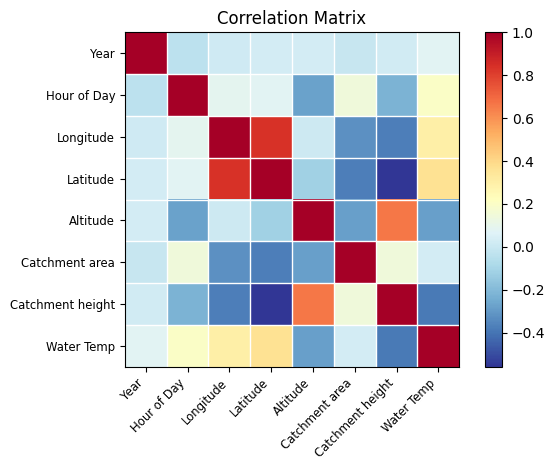

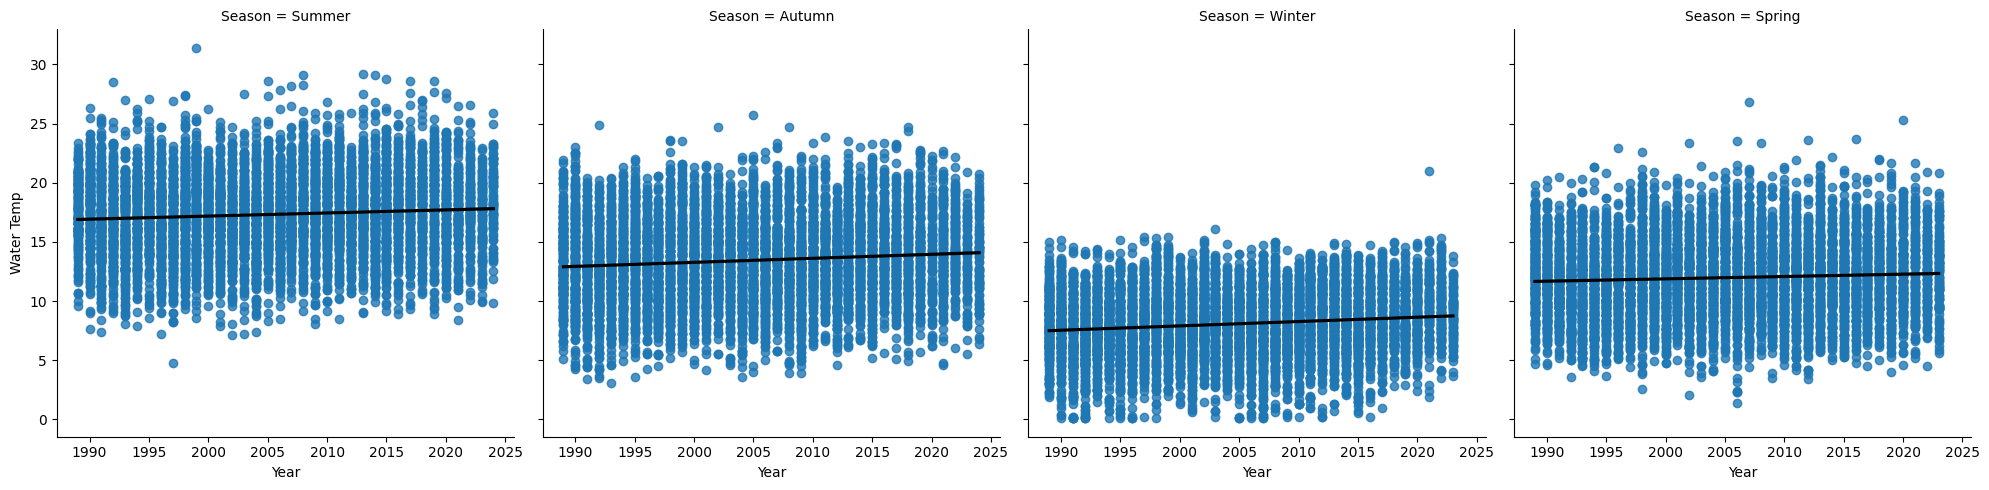

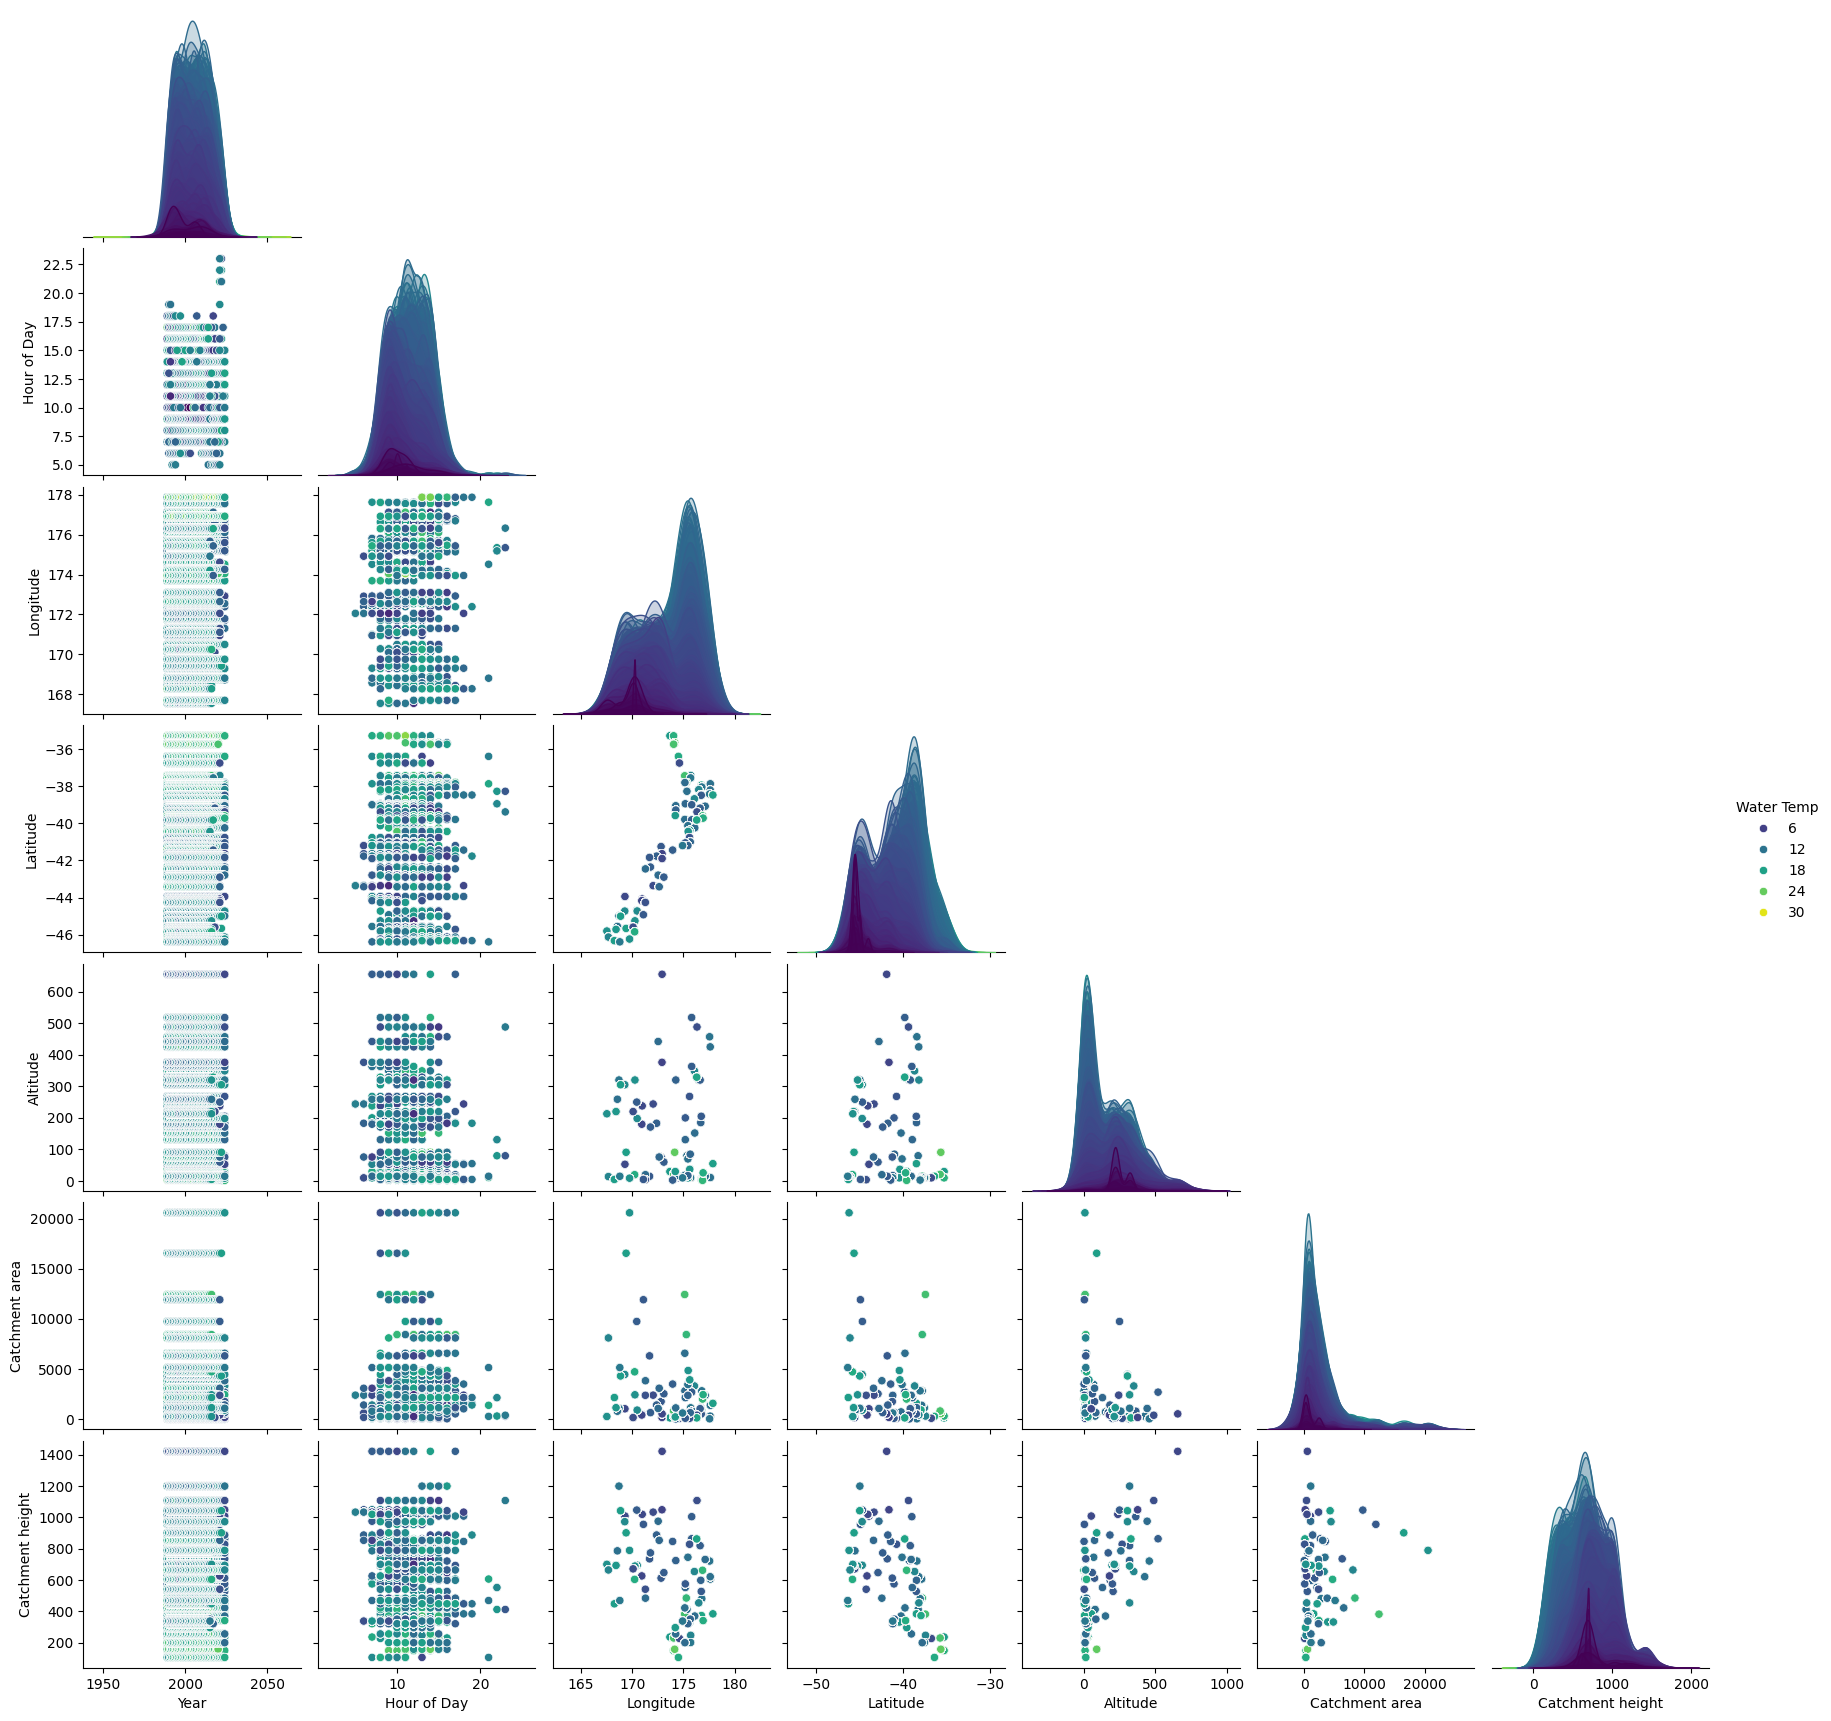

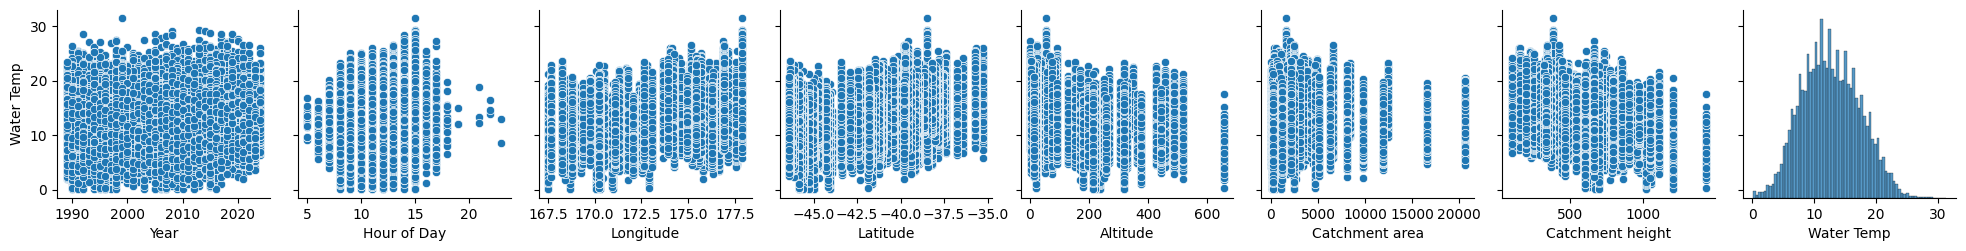

In [ ]:
import seaborn as sns

from matplotlib import pyplot as plt

from statsmodels.graphics.correlation import plot_corr

candidate_cols = [ 'Season', 'Year', 'Hour of Day', 'Longitude', 'Latitude', 'Altitude', 'Catchment area', 'Catchment height' ]
target_col = 'Water Temp'

candidate_data = all_data[candidate_cols + [ target_col ]].dropna()
display(candidate_data.info())

C = candidate_data.corr(numeric_only=True)
display(C)

plot_corr(C, xnames=C.columns)
plt.show()

sns.lmplot(candidate_data, x='Year', y='Water Temp', col='Season', line_kws={ 'color' : 'black' }, col_order=[ 'Summer', 'Autumn', 'Winter', 'Spring' ])
plt.show()

sns.pairplot(candidate_data, hue='Water Temp', palette='viridis', corner=True)
sns.pairplot(candidate_data, y_vars='Water Temp')
plt.show()

### Selected and Transformed Data

Based on the EDA, there is some reasonable evidence to justify excluding the Longitude and Altitude features from our modelling.

#### ___Justification for removing Longitude and Altitude___
Using the evidence from the EDA, justify the removal of the two features Longitude and Altitude:

___WRITE YOUR ANSWER HERE___

The correlation matrix reveals a strong relationship between longitude and latitude, suggesting that longitude may not add significant unique information. The scatter plot indicates a slight positive linear relationship, implying that as latitude increases, so does longitude. Since latitude measures distance from the equator, it provides valuable insights into climate and environmental conditions, such as New Zealand's proximity to Antarctica, which directly influences weather patterns. Given this context, the inclusion of longitude may be redundant, as latitude already captures essential geographical information.

When testing against water temperature, catchment height is more relevant than altitude because it directly influences factors like runoff, evaporation, and heat absorption in the water body. Catchment height affects how water flows into lakes or rivers, impacting temperature through variations in shading, vegetation, and thermal stratification. While altitude indicates elevation, it does not account for these localized conditions that significantly affect water temperature. Therefore, removing both longitude and altitude allows for a clearer and more accurate understanding of the variables influencing water temperature and simplifies the analysis by focusing on the most relevant factors.

### Model Data Setup

We can now select the data for modelling water temperature:

In [ ]:
target_col = 'Water Temp'
selected_features = [ 'Season', 'Year', 'Hour of Day', 'Latitude', 'Catchment height', 'Catchment area' ]
temp_data = all_data[selected_features + [ target_col ]].dropna()
temp_data

,Season,Year,Hour of Day,Latitude,Catchment height,Catchment area,Water Temp
0,Summer,1989,9,-35.2752,237,122.0,16.6
1,Summer,1989,9,-35.2752,237,122.0,16.6
2,Autumn,1989,10,-35.2752,237,122.0,17.5
3,Autumn,1989,9,-35.2752,237,122.0,14.7
4,Autumn,1989,9,-35.2752,237,122.0,9.5
...,...,...,...,...,...,...,...
30138,Spring,2023,9,-46.3911,470,5139.0,13.8
30139,Summer,2023,11,-46.3911,470,5139.0,13.4
30140,Summer,2024,9,-46.3911,470,5139.0,16.7
30141,Summer,2024,8,-46.3911,470,5139.0,16.1


#### ___Transformations: to ease the interpretation of the linear model, make some simple transformations to your data in `temp_data`:___

1. Subtract the minimum observed values from each of the `'Year'`, `'Latitude'` `'Catchment area'` and `'Catchment height'`
2. Divide `'Catchment height'` by 100 (to convert its units to '$/100m$')
3. Divide `'Catchment area'` by 1000 (to convert its units to '$/1000km^2$)

In [ ]:
### WRITE YOUR CODE HERE
import pandas as pd

# Assuming temp_data is your DataFrame
# Step 1: Subtract minimum observed values
temp_data['Year'] = temp_data['Year'] - temp_data['Year'].min()
temp_data['Latitude'] = temp_data['Latitude'] - temp_data['Latitude'].min()
temp_data['Catchment height'] = temp_data['Catchment height'] - temp_data['Catchment height'].min()
temp_data['Catchment area'] = temp_data['Catchment area'] - temp_data['Catchment area'].min()

# Step 2: Convert units
temp_data['Catchment height'] = temp_data['Catchment height'] / 100  # Convert to /100m
temp_data['Catchment area'] = temp_data['Catchment area'] / 1000  # Convert to /1000km²

# Display the transformed data
display(temp_data)


,Season,Year,Hour of Day,Latitude,Catchment height,Catchment area,Water Temp
0,Summer,0,9,11.1159,1.30,0.103,16.6
1,Summer,0,9,11.1159,1.30,0.103,16.6
2,Autumn,0,10,11.1159,1.30,0.103,17.5
3,Autumn,0,9,11.1159,1.30,0.103,14.7
4,Autumn,0,9,11.1159,1.30,0.103,9.5
...,...,...,...,...,...,...,...
30138,Spring,34,9,0.0000,3.63,5.120,13.8
30139,Summer,34,11,0.0000,3.63,5.120,13.4
30140,Summer,35,9,0.0000,3.63,5.120,16.7
30141,Summer,35,8,0.0000,3.63,5.120,16.1


### Linear Model

A simple linear model was established to relate Water Temperature to Year of recording. The results are shown below:
```
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q("Water Temp")   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     174.3
Date:                                   Prob (F-statistic):           1.09e-39
Time:                                   Log-Likelihood:                -88991.
No. Observations:               30071   AIC:                         1.780e+05
Df Residuals:                   30069   BIC:                         1.780e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1244      0.052    234.517      0.000      12.023      12.226
Q("Year")      0.0368      0.003     13.203      0.000       0.031       0.042
==============================================================================
Omnibus:                      512.519   Durbin-Watson:                   0.358
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              346.691
Skew:                           0.143   Prob(JB):                     5.21e-76
Kurtosis:                       2.559   Cond. No.                         35.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
```

The summary suggests that for every year, water temperature will increase by 0.0368 degrees (95% CI [0.031, 0.042]), suggesting an increase of around 0.37 degrees per decade. Your task here is to create a model detailed linear model and compare the resulting effect on the relationship between Water Temperature and the Year of recording.

#### ___Construct a more elaborate linear model___
Construct a linear model below to relate `'Water Temperature'` to the other features. At a minimum, you must include `'Season'` in the model, but you are free decide on what interactions you include for everything else. The `extract_model_stats()` may help you here (if you are not using statsmodels to construct your linear models):

In [ ]:
### WRITE YOUR CODE HERE
import seaborn as sns
from sklearn.datasets import make_friedman1
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import numpy as np

X = temp_data.drop(columns=target_col)
t = temp_data[target_col]

preprocessor = ColumnTransformer([
 ('dummy', OneHotEncoder(drop='first', sparse_output=False, dtype=int, feature_name_combiner=lambda feature, category: str(category)), [ 'Season' ]),
('season_hour_inter', categorical_numeric_interaction('Season', 'Hour of Day'), [ 'Season', 'Hour of Day' ])
], verbose_feature_names_out=False, remainder='passthrough', n_jobs=1).set_output(transform='pandas')

pipe = Pipeline([
('preprocess', preprocessor),
('model', LinearRegression())
])

pipe.fit(X, t)

extract_model_stats(pipe, X, t)







,Coefficient,Estimate,Std. Error,t value,Pr(>|t|),CI (lower),CI (upper),Sig?
0,Intercept,9.4187,0.163,57.690,0.000,9.099,9.739,***
1,Spring,-2.5639,0.206,-12.444,0.000,-2.968,-2.160,***
2,Summer,1.5283,0.204,7.493,0.000,1.129,1.928,***
3,Winter,-5.2478,0.211,-24.907,0.000,-5.661,-4.835,***
4,Hour of Day,0.2249,0.013,17.942,0.000,0.200,0.249,***
5,(Spring x Hour of Day),0.1002,0.018,5.694,0.000,0.066,0.135,***
6,(Summer x Hour of Day),0.2120,0.017,12.144,0.000,0.178,0.246,***
7,(Winter x Hour of Day),-0.0108,0.018,-0.605,0.545,-0.046,0.024,
8,Year,0.0307,0.001,21.145,0.000,0.028,0.033,***
9,Latitude,0.4281,0.006,73.837,0.000,0.417,0.439,***


#### ___Model Assessment___

Interpret your model below. Pay particular attention to the relationship between Water Temperature and Season and Water Temperature and Year of recording. Finally, place the relationship between Water Temperature and Year of recording in the context of larger predictions of rate of temperature increase (include a url or citation for your evidence)

___WRITE YOUR ANSWER HERE___

We can see that there’s a clear relationship between Water Temperature and Season, with Summer usually being the warmest, followed by Autumn, Spring, and Winter, which has much cooler temperatures. This makes sense, as we naturally expect warmer weather during the summer months. Looking at Water Temperature over the years, we might notice a trend showing that temperatures are gradually increasing. This is pretty concerning when we think about climate change. According to the National Oceanic and Atmospheric Administration (NOAA), global average ocean temperatures have gone up by about 0.8°C since the late 1800s, which can disrupt ecosystems.

Sea surface temperature increased during the 20th century and continues to rise. From 1901 through 2023, temperature rose at an average rate of 0.14°F per decade ) [(Figure 1)](https://www.epa.gov/climate-indicators/climate-change-indicators-sea-surface-temperature).


## Part 2: Modelling E. Coli (5 marks)

___(Supported by Lectures 8, 11, and 20, Labs 6 and 9, and Tutorial 8)___

In the next part, you will attempt to model the relationship between (log) E. Coli and other features in the data. The code below will set up the data for this exercise:

In [ ]:
from sklearn.model_selection import train_test_split

target_col = 'log(E. Coli)'
selected_columns = [
    'Catchment area', 'Catchment height', 'Absorbance Coefficient 340nm', 'Ammonia', 'Cloud Cover',
    'Oxygen', 'Total Nitrogen', 'Total Phosphate', 'Turbidity', 'Water Clarity', 'Water Temp', 'pH'
]

ecoli_data = all_data[selected_columns + [ target_col ]].dropna()

X = ecoli_data.drop(columns=target_col)
t = ecoli_data[target_col]

X_train, X_test, t_train, t_test = train_test_split(X, t, random_state=1234)

#### ___Construct a decision tree using cross validation to tune the model. Explore the following hyperparameters:___
* `'min_samples_split'` : `[ 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024 ]`
* `'splitter'` : `[ 'best', 'random' ]`

Train the model on the training data and score it on the test data. Produce a plot of the cross validation tuning process.

,model__min_samples_split,model__splitter,split,test_score
0,2,best,1,1.835232
1,2,random,1,1.933464
2,4,best,1,1.829516
3,4,random,1,1.632221
4,8,best,1,1.710811
...,...,...,...,...
595,256,random,30,1.506088
596,512,best,30,1.399763
597,512,random,30,1.583352
598,1024,best,30,1.589530


<Axes: xlabel='model__min_samples_split', ylabel='test_score'>

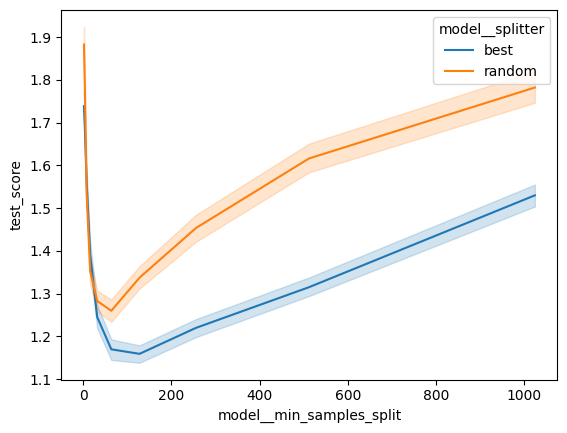

In [ ]:
### WRITE YOUR CODE HERE
import seaborn as sns
from sklearn.datasets import make_friedman1
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np


cv_folds = RepeatedKFold(n_repeats=3, n_splits=10, random_state=1234)
tuning_grid = {
'model__min_samples_split' : [ 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024 ],
'model__splitter' : [ 'best', 'random' ]
                }

dt_pipe = Pipeline([
    ('preprocess', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

dtcv = GridSearchCV(dt_pipe, param_grid = tuning_grid, cv=cv_folds, n_jobs=-1, scoring = 'neg_mean_squared_error')
dtcv.fit(X_train, t_train)
cvdata = extract_cv_results(dtcv)
display(cvdata)
sns.lineplot(cvdata, x='model__min_samples_split', y='test_score', hue='model__splitter')

#### ___Construct a random forest on the data___

In the code cell below, write code that constructs a random forest regressor on the training data and scores the model on the test data

<Axes: xlabel='min_samples_split', ylabel='test_score'>

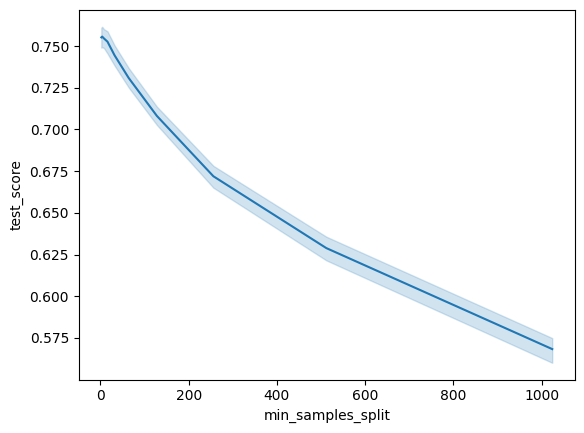

In [ ]:
### WRITE YOUR CODE HERE
import seaborn as sns
from sklearn.datasets import make_friedman1
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

cv_folds = RepeatedKFold(n_repeats=3, n_splits=10, random_state=1234)
tuning_grid = {
'min_samples_split' : [ 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024 ],
                }

dtcv = GridSearchCV(RandomForestRegressor(), tuning_grid, cv=cv_folds, n_jobs=-1)
dtcv.fit(X_train, t_train)
cvdata = extract_cv_results(dtcv)
# display(cvdata)
sns.lineplot(cvdata, x='min_samples_split', y='test_score',)

#### ___Argue why the random forest was able to outperform the single decision tree, desipte the use of cross validation to tune the single tree. You should relate your justification to the bias-variance tradeoff:___

___WRITE YOUR ANSWER HERE__

You can reduce the varience in a random forest as you can perform bagging. Baggis is reducing the varience without changing the already low bias.
Random forests outperform single decision trees due to the bias-variance tradeoff. A single decision tree tends to have high variance, often overfitting the training data and performing poorly on unseen data. Random forests contrast this. By averaging the results from diverse trees, random forests achieve a more robust model which captures patterns without being sensitive to noise in the training data.




#### ___One criticism of ensemble methods is that they are harder to interpret. In the cell below, use a method described in labs (permutation importance) to extract some knowledge from the ensemble:___

Baseline MSE: 3.6024


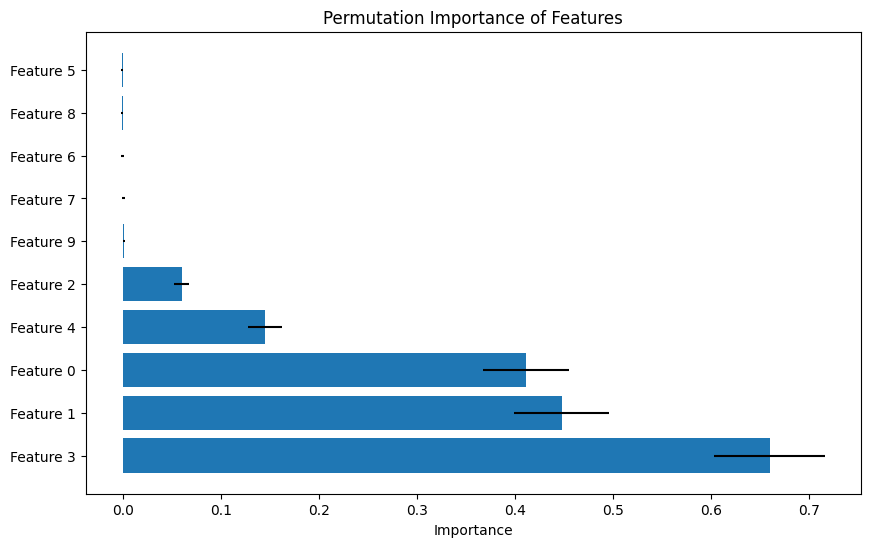

In [ ]:
### WRITE YOUR CODE HERE
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_friedman1
import matplotlib.pyplot as plt

X, y = make_friedman1(n_samples=1000, noise=0.1, random_state=123)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(random_state=1234)
model.fit(X_train, y_train)


baseline_preds = model.predict(X_val)
baseline_mse = mean_squared_error(y_val, baseline_preds)
print(f"Baseline MSE: {baseline_mse:.4f}")


results = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=42)


importance_df = pd.DataFrame({
    'Feature': [f'Feature {i}' for i in range(X.shape[1])],
    'Importance': results.importances_mean,
    'Std Dev': results.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std Dev'])
plt.xlabel('Importance')
plt.title('Permutation Importance of Features')
plt.show()


## Part 1-2 BONUS MARKS (optional)
You may answer this question to regain up to two marks that you lost in the _previous_ exercises for Parts 1 and 2.

Note that the answer to this question has not been discussed in classes, so you may have to do your own research/exploration to help answer this!

#### ___Question: the models that you developed in this section may provide insight and knowledge, but CANNOT be reliably used for prediction - why? What processing would be needed to the data and/or algorithms to make it possible to produce prediction models?___

___WRITE YOUR ANSWER HERE___

The models developed in this section may provide valuable insights but cannot be reliably used for prediction. First, they may suffer from overfitting, where the model captures noise in the training data rather than the underlying patterns, leading to poor performance on unseen data. Data leakage is a problem we may face as it can occur if the validation set is not properly separated during model training. Effective predictive models require thorough data preprocessing and addressing outliers.



## Part 3: Data Ethics and Māori Data Sovereignty (10 marks)

___(Supported by Lectures 17-19, and Tutorials 8 and 9)___

[Te Hiku Media](https://tehiku.nz/) and [Stuff](https://www.stuff.co.nz/) have adopted two vastly different policies towards embracing artificial intelligence methods for language transltion in a te reo Māori context:

* [OpenAI's Whisper is another case study in Colonisation](https://blog.papareo.nz/whisper-is-another-case-study-in-colonisation/)
* [AI strengthens te reo Māori use at NZ’s largest digital news site ](https://advertise.stuff.co.nz/news/ai-strengthens-te-reo-maori-use-nzs-largest-digital-news-site)

Both Stuff and Te Hiku Media have made cases to support the approaches that they have taken.

#### ___Write a brief essay (no word limit, but 750-1000 words would be a reasonable target) that examines the two approaches taken by Stuff and Te Hiku Media. Include a brief background relevant to each case (e.g., motivations and solutions adopted) Your answer should address benefits _AND_ risks associated with each approach, and ideally examine each approach using aspects of the [Te Mana Rarunga](https://www.temanararaunga.maori.nz/) principles mentioned in lectures.___

___WRITE YOUR ANSWER HERE___



The Role of AI Language Models in Preserving Indigenous Languages: Benefits and Concerns

__Introduction__

The world has been taken by storm from the generational development in Artificial Intelligence (AI), changing daily tasks and altering our interactions with technology. AI shows great potential in preserving and reviving endangered Indigenous languages. Language is not just a means of communication, it is the foundation of culture and identity, the cornerstone to Indigenous groups working to protect their heritage and past. AI language models from OpenAI and Google can assist in preservation through machine learning, but they also bring up challenging questions related to data control, morality, and purpose. Despite the potential of AI language models in preserving Indigenous languages, there are serious concerns about the exploitation of data and the lack of accountability from corporations

__I. Benefits of AI Language Models for Indigenous Languages__
One of the most captivating benefits of AI language models is the ability to have a "seed bank" of all languages around the world, preserving endangered languages. Numerous languages around the world are at risk of extinction, and AI could be the powerful tool to counteract this trend. AI can store, learn, and generate resources for these languages, helping communities document and archive their knowledge and history. AI backed tools like translation tools, digital dictionaries, and speech recognition can make languages more accessible to the generations after us and to people living outside their traditional homelands. For instance, the New Zealand government has set a goal of having one million speakers of te reo Māori by 2040, a goal that can be supported by digital tools designed to teach and promote the language.

Beyond preservation, AI can increase the accessibility of Indigenous languages in digital spaces. This is crucial as Indigenous languages often face hurdles in mainstraeming their culture and langauge, even in countries where they are officially recognized. AI technology, such as digital assistants and automated captioning systems which can integrate languages into mainstream platforms, thereby normalizing their use in everyday life. For example, Māori-speaking Siri or automated captioning for te reo Māori would significantly contribute to making the language more common and accessible. Such technology would not only help speakers but also support language learners by making it easier to interact.

In addition to increasing visibility, AI language models can directly contribute to language revitalization. AI tools can be used to build language learning apps or courses, providing a learning experience for those looking to reconnect with their heritage or a new language. These tools can help the education of all across the globe, especially those displaced from their homelands, to retain or relearn their languages. This is particularly important as many Indigenous peoples were historically prohibited from speaking their languages, leading to generational language loss. AI can serve as a tool to reverse this detrimental process. This is present in many countries across the globe which would make it very enticing for big corporations to get their own fingers in the pie.

__II. Potential Issues and Concerns with AI Language Models__
While the benefits of AI language models are significant, they come with major concerns which can't be overlooked. A high pressing issue, is the risk of data extraction and exploitation. AI models require vast amounts of data to work effectively. Vulnerable communities often become the source of such data without their explicit consent. This leads to what can be described as a form of extractive capitalism, where corporations profit from Indigenous knowledge without returning any benefits to the communities from which the data originates. A clear example is Amazon’s Polly voice service, which includes a te reo Māori voice named Aria. This may seem like a step towards the right direction in promoting te reo Māori, the reality is that large corporations like Amazon stand to profit from selling Māori language services without directly advancing the Māori community itself .

Another major concern is the issue of data sovereignty. Many communities across the globe have fought for centuries for land, rights, and cultural heritage. In the tech age, data sovereignty outlines the right to control how Indigenous data is collected, stored, and used. Large corporations such as Google, Amazon, and Microsoft, despite building data centers in Aotearoa (New Zealand), can not be truly accountable to Māori data sovereignty laws. In fact, under U.S. law (via the CLOUD Act), American companies can be obligated to share data stored in foreign data centers with the U.S. government, undermining local data sovereignty protections. This raises deep concerns about the security and control of Indigenous data held by big overseas corporations.

In addition to concerns about exploitation and sovereignty, minoritized communities often lack the resources to fully benefit from open-source AI technology. While companies like OpenAI release technology like Whisper with the stated aim of democratizing access to technology. In reality, access to these tools is still limited to those with high-speed internet, advanced computers, and technical expertise. Indigenous communities, which are often underfunded by infrastructure and resources, are left behind. This means that the benefits of open-source AI largely skew to those who are already part of the tech industry and largely developed cities and part of the world.

__III. Ethical and Cultural Concerns in AI Development__
Who controls how Indigenous languages are used in AI technology is a huge ethical concern. Decision making around the use of Indigenous languages in AI should not be in the hands of Big Tech companies. These decisions should rest with the local communities, those who have the most at stake in how their cultural heritage is represented and commercialized. However, even within Indigenous communities, internal politics can complicate decision-making. For example, in Māori culture, it is not up to a single individual or government agency to decide the fate of the language. Instead, decisions are made collectively, often with guidance from elders (kaumātua) who have spent decades working on language revitalization efforts. Te Hiku Media, a Māori-owned and -operated media organization, provides an example of this. They seek advice from kaumātua and language revitalization experts to ensure that any AI tools built around te reo Māori align with community values and goals, which can be largely time consuming however is very worth while for the people.

Indigenous communities should be at the fore-front of how their language data is used and should have the opportunity to profit from its use. Companies that attempt to commercialize Indigenous languages without returning benefits to the communities are essentially perpetuating colonial practices. As Te Hiku Media asserts, only Māori should have the right to sell Māori language services, given that non-Māori once attempted to make the language extinct .

__IV. Long-Term Impacts and Solutions__
Looking to the future, respecting Indigenous data is critical. All cultures instil values which emphasise respect for their own culture such as the environment(Kaitiakitanga) and Manaakitanga. Those dealing with data must be respectful and display similar values when dealing with Indigenous data. Treating data with care and ensuring that communities have control over how their language is used. Data should not be seen as a profitable commodity which can be exploited but as part of the cultural ecosystem that must be protected and respected.

Partnerships that allow for an even stake in the handling and decision making process is essential and the future for the ethical use of AI. Indigenous-led organizations like Te Hiku Media have shown how successful partnerships can be when Maori voices are at the forefront of technological development and equal partners can be just as successful. These collaborations ensure that language revitalization efforts align with the goals and values of the community, rather than the profit-driven interests of corporations.

__Conclusion__
AI language models offer exciting possibilities for preserving and revitalizing endangered and threatened languages, however it is crucial to ensure the development and deployment is in a way that shows Tikanga and respects Indigenous data sovereignty and cultural integrity. As the world is revolutionised by technology, it is vital involvement, and incorporation of Indigenous communities in the decision-making process. By fostering ethical and equitable collaboration, AI can be a tool for cultural preservation rather than modern exploitation, helping to ensure that Indigenous languages not only survive but thrive in the digital age.